# **Data Cleaning:**
Summarize what we did in Excel, and some stuff moving into python
- dawg i had to manually remove values because 1). the list is so small, 2). not that hard as a result 3). excel/python would take more time
- deleted non 2021-2022 columns 
- In excel, for athabasca, bruderheim,etc. used excel to isolate just unit types, then finished cleaning in pandas

In [1]:
# further data cleaning in pandas
import pandas as pd
pd.options.mode.chained_assignment = None # 

# read datasets
table6 = pd.read_csv("Matthew's Data/Table6.csv")
table8 = pd.read_csv("Matthew's Data/Table8.csv")
table9 = pd.read_csv("Matthew's Data/table9.csv")

# create list of all strings that contain the names of communities in table 8
community_names = table8["Community"].unique().tolist()

# filter the csv based on if it exists in the observed commmunities
table9_byAreaNames = table9[table9["Area Name"].isin(community_names)]

# IMPUTATION WARNING: the only value  
table9_byAreaNames.loc[table9_byAreaNames["Area Name"] == "Grande Cache"] = table9_byAreaNames.loc[table9_byAreaNames["Area Name"] == "Grande Cache"].replace("--", "3276")

# convert 2022 and 2021 column to integer values (since it is currently being read as string)
table9_byAreaNames["2022"] = table9_byAreaNames["2022"].apply(lambda x: int(x))
table9_byAreaNames.drop(["2021"],axis=1,inplace=True)

# display populations (alphabetical order)
table9_cleaned = table9_byAreaNames.sort_values("Area Name")
table9_cleaned
        

,Area Name,Type,2022
308,Athabasca,T,2827
330,Banff,T,9347
296,Barrhead,T,4503
26,Bassano,T,1255
409,Beaverlodge,T,2371
...,...,...,...
183,Vegreville,T,5819
190,Vermilion,T,3978
59,Vulcan,T,1825
131,Wainwright,T,6741


For this data set, it was at some point much easier to clean manually than it was to use excel or python, due to the fact that in this check, less than 15 were absent due to some error, and was as a result, so using ctrl + f and manually editing was not (in general, it isn't a practical solution but here is somehow less time consuming than using python/excel)

New changes
- removed commas in thousands from Table 8 --> can read as numerical values now
- removed "Overall Vacancy Rates" from Table 8, since this is covered in table 6 and is more accurate there, just need the weighted rents between years in table 8\
- added "population" which we want to analyze how town population sizes might also be related to costs and shit
    - add to faceted graph as an outer variable

In [2]:
# remove table8 zeroes (since this is false data)
table8 = table8[table8["2021 Weighted Rent"] != 0]
table8 = table8[table8["2022 Weighted Rent"] != 0]

table8

,Community,Unit Type,2021 Weighted Rent,2022 Weighted Rent
0,Athabasca,1 - Bedroom,840,852
1,Athabasca,2 - Bedroom,912,931
2,Athabasca,3 - Bedroom,1026,980
3,Athabasca,Bachelor,706,719
4,Banff,1 - Bedroom,1318,1435
...,...,...,...,...
247,Wainwright,Bachelor,450,434
248,Westlock,1 - Bedroom,775,768
249,Westlock,2 - Bedroom,881,881
250,Westlock,3 - Bedroom,972,963


For each of the individual community summaries:
- Did a bit of cleaning in Excel to reformat and just get number/percent by unit type
- Rest of cleaning done in pandas

--------------------------------------------
### **Cleaning data for individual summaries**

- Extracted 

In [46]:
# Individual Vacancies for Bruderheim 
bruderheim_vacancies = pd.read_csv("Matthew's Data/Summaries/Bruderheim Summary.csv")

bruderheim_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)

# Explain this as a result of some of them having this issue
bruderheim_vacancies = bruderheim_vacancies.dropna(how='all',axis=1)
bruderheim_vacancies = bruderheim_vacancies.dropna(how='all',axis=0)

# Add 2021 Vacancies:
bruderheim_vacancies_2021 = pd.DataFrame({
    "Bachelor": [4,1,0.25], 
    "1 - Bedroom":[36,19, 0.528], 
    "2 - Bedroom": [36, 11, 0.306], 
    "3 - Bedroom": [4, 0, 0], 
    "4+ Bedroom": [80,31,0.388]})

# "index setter" for all 
attributes = bruderheim_vacancies.index

bruderheim_vacancies_2021.index = attributes
bruderheim_vacancies = pd.concat([bruderheim_vacancies_2021, bruderheim_vacancies], axis=1)

# Multilevel Indexing
multigrouping = [("2021", "Bachelor"),
                    ("2021", "1 - Bedroom"),
                    ("2021", "2 - Bedroom"), 
                    ("2021", "3 - Bedroom"),
                    ("2021", "4+ Bedroom"),
                    ("2022", "Bachelor"),
                    ("2022", "1 - Bedroom"),
                    ("2022", "2 - Bedroom"), 
                    ("2022", "3 - Bedroom"),
                    ("2022", "4+ Bedroom"),]

bruderheim_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)

bruderheim_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                        4.00      36.000   
Vacancies                                              1.00      19.000   
Percentage                                             0.25       0.528   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                         36.000           4   
Vacancies                                               11.000           0   
Percentage                                               0.306           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                        80.000      4.0   
Vacancies                                              31.000      2.0   
Percentage                                              0.388      0.5   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                         36.000      36.000   
Vacancies                                               19.000      12.000   
Percentage                                               0.528       0.333   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                           4.00        0.0  
Vacancies                                                 3.00        0.0  
Percentage                                                0.75        0.0

In [47]:
foxcreek_vacancies = pd.read_csv("Matthew's Data/Summaries/Fox Creek Summary.csv")
foxcreek_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)

foxcreek_vacancies_2021 = pd.DataFrame({
    "Bachelor": [3,0,0], 
    "1 - Bedroom":[57,28, 0.491], 
    "2 - Bedroom": [109, 62, 0.569], 
    "3 - Bedroom": [14, 5, 0.357], 
    "4+ Bedroom": [0,0,0]})

foxcreek_vacancies_2021.index = attributes
foxcreek_vacancies = pd.concat([foxcreek_vacancies_2021, foxcreek_vacancies], axis=1)

foxcreek_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
foxcreek_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           3      57.000   
Vacancies                                                 0      28.000   
Percentage                                                0       0.491   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                        109.000      14.000   
Vacancies                                               62.000       5.000   
Percentage                                               0.569       0.357   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      1.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                         36.000      55.000   
Vacancies                                               21.000      35.000   
Percentage                                               0.583       0.636   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            5.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

In [48]:
falher_vacancies = pd.read_csv("Matthew's Data/Summaries/Falher Summary.csv")
falher_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
falher_vacancies = falher_vacancies.dropna(how='all',axis=1)
falher_vacancies = falher_vacancies.dropna(how='all',axis=0)

falher_vacancies_2021 = pd.DataFrame({
    "Bachelor": [2,0,0], 
    "1 - Bedroom":[18,0,0], 
    "2 - Bedroom": [21, 1, 0.048], 
    "3 - Bedroom": [7, 1, 0.143], 
    "4+ Bedroom": [0,0,0]})

falher_vacancies_2021.index = attributes
falher_vacancies = pd.concat([falher_vacancies_2021, falher_vacancies], axis=1)

falher_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)

falher_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           2          18   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                         21.000       7.000   
Vacancies                                                1.000       1.000   
Percentage                                               0.048       0.143   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      2.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                          20.00      24.000   
Vacancies                                                 3.00       2.000   
Percentage                                                0.15       0.083   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                          7.000        0.0  
Vacancies                                                1.000        0.0  
Percentage                                               0.143        0.0

In [ ]:
highprairie_vacancies = pd.read_csv("Matthew's Data/Summaries/High Prairie Summary.csv")
highprairie_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)

highprairie_vacancies_2021 = pd.DataFrame({
    "Bachelor": [12,2,0.167], 
    "1 - Bedroom":[81,2,0.025], 
    "2 - Bedroom": [31, 3, 0.097], 
    "3 - Bedroom": [1, 0, 0], 
    "4+ Bedroom": [0,0,0]})

highprairie_vacancies_2021.index = attributes
highprairie_vacancies = pd.concat([highprairie_vacancies_2021, highprairie_vacancies], axis=1)

highprairie_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)

highprairie_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                      12.000      81.000   
Vacancies                                             2.000       2.000   
Percentage                                            0.167       0.025   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                         31.000           1   
Vacancies                                                3.000           0   
Percentage                                               0.097           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0   11.000   
Vacancies                                                   0    2.000   
Percentage                                                  0    0.182   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                         97.000      36.000   
Vacancies                                                9.000       6.000   
Percentage                                               0.093       0.167   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                           13.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

In [ ]:
tofield_vacancies = pd.read_csv("Matthew's Data/Summaries/Tofield Summary.csv")
tofield_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
tofield_vacancies = tofield_vacancies.dropna(how='all',axis=1)
tofield_vacancies = tofield_vacancies.dropna(how='all',axis=0)

tofield_vacancies_2021 = pd.DataFrame({
    "Bachelor": [1,0,0], 
    "1 - Bedroom":[3,0,0], 
    "2 - Bedroom": [2,0,0], 
    "3 - Bedroom": [3,0,0], 
    "4+ Bedroom": [0,0,0]})

tofield_vacancies_2021.index = attributes
tofield_vacancies = pd.concat([tofield_vacancies_2021, tofield_vacancies], axis=1)

tofield_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
tofield_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           1           3   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                              2           3   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0        1   
Vacancies                                                   0        0   
Percentage                                                  0        0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                              4          13   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                              7          0  
Vacancies                                                    0          0  
Percentage                                                   0          0

In [ ]:
millet_vacancies = pd.read_csv("Matthew's Data/Summaries/Millet Summary.csv")
millet_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
millet_vacancies = millet_vacancies.dropna(how='all',axis=1)
millet_vacancies = millet_vacancies.dropna(how='all',axis=0)

millet_vacancies_2021 = pd.DataFrame({
    "Bachelor": [0,0,0], 
    "1 - Bedroom":[4,1,0.25], 
    "2 - Bedroom": [15,2,0.133], 
    "3 - Bedroom": [0,0,0], 
    "4+ Bedroom": [0,0,0]})

millet_vacancies_2021.index = attributes
millet_vacancies = pd.concat([millet_vacancies_2021, millet_vacancies], axis=1)

millet_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
millet_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           0        4.00   
Vacancies                                                 0        1.00   
Percentage                                                0        0.25   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                         15.000           0   
Vacancies                                                2.000           0   
Percentage                                               0.133           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      0.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                            5.0        14.0   
Vacancies                                                  0.0         0.0   
Percentage                                                 0.0         0.0   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            0.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

In [ ]:
mclennan_vacancies = pd.read_csv("Matthew's Data/Summaries/Mclennan Summary.csv")
mclennan_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
mclennan_vacancies = mclennan_vacancies.dropna(how='all',axis=1)
mclennan_vacancies = mclennan_vacancies.dropna(how='all',axis=0)

mclennan_vacancies_2021 = pd.DataFrame({
    "Bachelor": [0,0,0], 
    "1 - Bedroom":[12,0,0], 
    "2 - Bedroom": [15,0,0], 
    "3 - Bedroom": [0,0,0], 
    "4+ Bedroom": [0,0,0]})

mclennan_vacancies_2021.index = attributes

mclennan_vacancies = pd.concat([mclennan_vacancies_2021, mclennan_vacancies], axis=1)

mclennan_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
mclennan_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           0          12   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                             15           0   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      0.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                         12.000        12.0   
Vacancies                                                1.000         0.0   
Percentage                                               0.083         0.0   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            0.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

In [51]:
# Jasper
# have to manually impute the values from the linked pdf since sheet didn't have it (https://open.alberta.ca/dataset/fb9452c6-395e-45a8-8149-645956fd83ac/resource/e07f0421-a710-4c3c-9bbf-392285493e6b/download/scss-apartment-vacancy-rental-cost-survey-2022.pdf)
jasper_vacancies = pd.DataFrame({
    "Bachelor": [149,0,0], 
    "1 - Bedroom":[112,0,0], 
    "2 - Bedroom": [75,0,0], 
    "3 - Bedroom": [21,0,0], 
    "4+ Bedroom": [0,0,0]
})
jasper_vacancies.index = attributes

jasper_vacancies2021 = pd.DataFrame({
    "Bachelor": [147,0,0], 
    "1 - Bedroom":[82,0,0], 
    "2 - Bedroom": [26,0,0], 
    "3 - Bedroom": [2,0,0], 
    "4+ Bedroom": [0,0,0]
})
jasper_vacancies2021.index = attributes

jasper_vacancies = pd.concat([jasper_vacancies2021, jasper_vacancies], axis=1)
jasper_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)

jasper_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                         147          82   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                             26           2   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      149   
Vacancies                                                   0        0   
Percentage                                                  0        0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                            112          75   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                             21          0  
Vacancies                                                    0          0  
Percentage                                                   0          0

In [ ]:
# medtowns = ["Barrhead","Westlock", "Claresholm", "Grimshaw", "Raymond", "Fort Macleod"]
# Barrhead


In [53]:
# Banff (also manually create data)
banff_vacancies = pd.DataFrame({
    "Bachelor": [12,0,0], 
    "1 - Bedroom":[91,1,0.011], 
    "2 - Bedroom": [179,0,0], 
    "3 - Bedroom": [94,0,0], 
    "4+ Bedroom": [2,0,0]
})
banff_vacancies.index = attributes

banff_vacancies2021 = pd.DataFrame({
    "Bachelor": [51,0,0], 
    "1 - Bedroom":[99,2,0.02], 
    "2 - Bedroom": [133,7,0.053], 
    "3 - Bedroom": [58,0,0.034], 
    "4+ Bedroom": [2,0,0]
})
banff_vacancies2021.index = attributes

banff_vacancies = pd.concat([banff_vacancies2021, banff_vacancies], axis=1)
banff_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)

banff_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                          51       99.00   
Vacancies                                                 0        2.00   
Percentage                                                0        0.02   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                        133.000      58.000   
Vacancies                                                7.000       0.000   
Percentage                                               0.053       0.034   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             2       12   
Vacancies                                                   0        0   
Percentage                                                  0        0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                         91.000         179   
Vacancies                                                1.000           0   
Percentage                                               0.011           0   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                             94          2  
Vacancies                                                    0          0  
Percentage                                                   0          0

-------

# **Visualizations + Analysis:**

Potential Conclusions from these visuals:
- This one is pretty much just number of vacancies relative to the number of units over rental ranges
- Overall, for the most part pretty much mostly, the vacancies tend to be proportional to the number of units in that range

In [11]:
# TASKS FOR FRIDAY:
# TODO plot all of the sampled small towns --> bar graph as well as line graph
# TODO pick 4-5 medium towns and do the same
# TODO pick 4-5 big towns (one of which should include Slave Lake) and do the same

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# get mean rent by each unit type for both 2021 and 2022
mean_bachelors2022 = table8[table8["Unit Type"] == "Bachelor"]["2022 Weighted Rent"].mean()
mean_1beds2022 = table8[table8["Unit Type"] == "1 - Bedroom"]["2022 Weighted Rent"].mean()
mean_2beds2022 = table8[table8["Unit Type"] == "2 - Bedroom"]["2022 Weighted Rent"].mean()
mean_3beds2022 = table8[table8["Unit Type"] == "3 - Bedroom"]["2022 Weighted Rent"].mean()
mean_4beds2022 = table8[table8["Unit Type"] == "4+ Bedroom"]["2022 Weighted Rent"].mean()

mean_bachelors2021 = table8[table8["Unit Type"] == "Bachelor"]["2021 Weighted Rent"].mean()
mean_1beds2021 = table8[table8["Unit Type"] == "1 - Bedroom"]["2021 Weighted Rent"].mean()
mean_2beds2021 = table8[table8["Unit Type"] == "2 - Bedroom"]["2021 Weighted Rent"].mean()
mean_3beds2021 = table8[table8["Unit Type"] == "3 - Bedroom"]["2021 Weighted Rent"].mean()
mean_4beds2021 = table8[table8["Unit Type"] == "4+ Bedroom"]["2021 Weighted Rent"].mean()

print("2021 Mean Bachelor Rents:",mean_bachelors2021)
print("2021 Mean 1 - Bedroom Rents:",mean_1beds2021)
print("2021 Mean 2 - Bedroom Rents:",mean_2beds2021)
print("2021 Mean 3 - Bedroom Rents:",mean_3beds2021)
print("2021 Mean 4+ Bedroom Rents:",mean_4beds2021)

print()

print("2022 Mean Bachelor Rents:",mean_bachelors2022)
print("2022 Mean 1 - Bedroom Rents:",mean_1beds2022)
print("2022 Mean 2 - Bedroom Rents:",mean_2beds2022)
print("2022 Mean 3 - Bedroom Rents:",mean_3beds2022)
print("2022 Mean 4+ Bedroom Rents:",mean_4beds2022)

2021 Mean Bachelor Rents: 688.741935483871
2021 Mean 1 - Bedroom Rents: 779.925925925926
2021 Mean 2 - Bedroom Rents: 900.6101694915254
2021 Mean 3 - Bedroom Rents: 1036.625
2021 Mean 4+ Bedroom Rents: 1625.0

2022 Mean Bachelor Rents: 702.741935483871
2022 Mean 1 - Bedroom Rents: 826.0
2022 Mean 2 - Bedroom Rents: 943.1186440677966
2022 Mean 3 - Bedroom Rents: 1064.6041666666667
2022 Mean 4+ Bedroom Rents: 1708.6


In [14]:
# Divide population into different sizes
population_labels, population_bins = pd.qcut(table9_cleaned["2022"], 3, retbins=True) # 
print("Bin Divisions:",population_bins.astype(int))

Bin Divisions: [  719  2492  5760 14996]


This means we are going to divide the population as:
- Small: [719, 2492]
- Medium: (2492, 5760]
- Large: (5760, 14996]

*([] = Included, () = Excluded)*

In [15]:
# helper function for plotting means
# def plotmeans(bach, one, two, three, four):

--------------

## **Analysis of Small Communities**

*(Population Size: 719-2492)*

In [16]:
# list of "small" towns (size 719-2492)
small_towns = table9_cleaned[table9_cleaned["2022"].between(population_bins[0], population_bins[1])]
small_towns

# TODO filter again but just for the towns we are looking at

,Area Name,Type,2022
26,Bassano,T,1255
409,Beaverlodge,T,2371
4,Bow Island,T,2129
137,Bowden,T,1297
202,Bruderheim,T,1392
145,Eckville,T,1079
260,Elk Point,T,1455
417,Falher,T,1034
401,Fox Creek,T,1841
48,Hanna,T,2492


In [ ]:
# Sampled Small Towns: Bruderheim, Fox Creek, Falher, High Prairie, Tofield, Millet, Mclennan
smalltowns = ["Bruderheim", "Fox Creek", "Falher", "High Prairie", "Tofield", "Millet", "Mclennan"]
costs_smalltowns = table8[table8["Community"].isin(smalltowns)]
vacancy_smalltowns = table6[table6["Community"].isin(smalltowns)]

bruderheim = costs_smalltowns[costs_smalltowns["Community"] == "Bruderheim"]
foxcreek = costs_smalltowns[costs_smalltowns["Community"] == "Fox Creek"]
falher = costs_smalltowns[costs_smalltowns["Community"] == "Falher"]
highprairie = costs_smalltowns[costs_smalltowns["Community"] == "High Prairie"]
tofield = costs_smalltowns[costs_smalltowns["Community"] == "Tofield"]
millet = costs_smalltowns[costs_smalltowns["Community"] == "Millet"] # TODO Compare Mclennan & Millet
mclennan = costs_smalltowns[costs_smalltowns["Community"] == "Mclennan"]

bruderheim_rents = bruderheim[["2021 Weighted Rent", "2022 Weighted Rent"]]
foxcreek_rents = foxcreek[["2021 Weighted Rent", "2022 Weighted Rent"]]
falher_rents = falher[["2021 Weighted Rent", "2022 Weighted Rent"]]
highprairie_rents = highprairie[["2021 Weighted Rent", "2022 Weighted Rent"]]
tofield_rents = tofield[["2021 Weighted Rent", "2022 Weighted Rent"]]
millet_rents = millet[["2021 Weighted Rent", "2022 Weighted Rent"]]
mclennan_rents = mclennan[["2021 Weighted Rent", "2022 Weighted Rent"]]

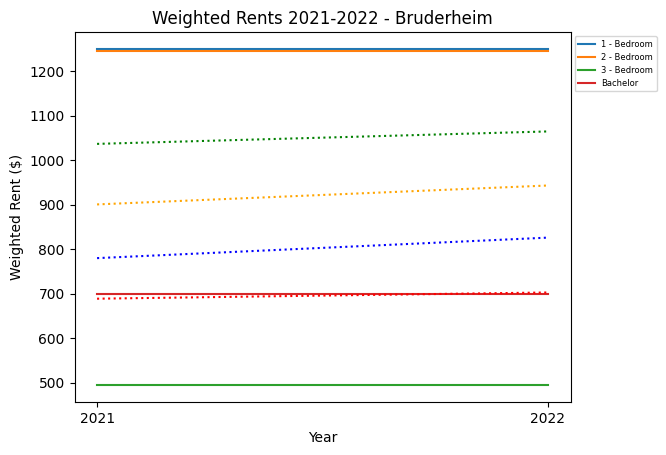

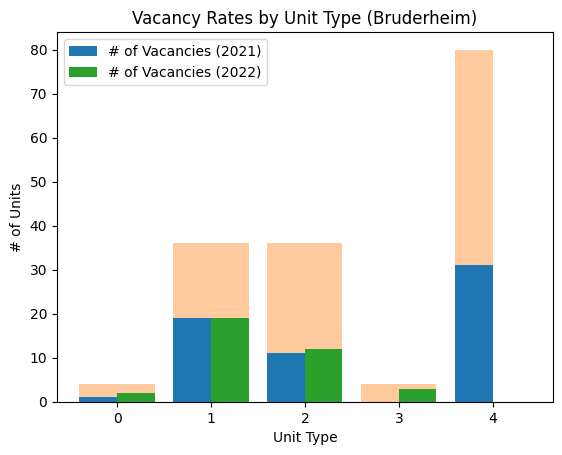

In [18]:
# Why we used this? --> Extreme Case 1: Bruderheim (Literally exactly the same rent between both for all units --> massive difference from rent prices)
for i in range(len(bruderheim.index)):
    plt.plot(["2021", "2022"], bruderheim_rents.iloc[i], label=bruderheim["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Bruderheim") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

# plot bar graphs of individual unit vacancies
vacancy_2021 = np.array(bruderheim_vacancies["2021"].loc["Vacancies"])
vacancy_2022 = np.array(bruderheim_vacancies["2022"].loc["Vacancies"])

num_units_2021 = np.array(bruderheim_vacancies["2021"].loc["Number of Units"])
num_units_2022 = np.array(bruderheim_vacancies["2022"].loc["Number of Units"])

x_range = np.arange(len(bruderheim_vacancies["2021"].columns)) # create (also allows us to offset the bars)

plt.bar(x_range - 0.2, vacancy_2021, 0.4, label="# of Vacancies (2021)")
plt.bar(x_range - 0.2, num_units_2021 - vacancy_2021, 0.4, bottom=vacancy_2021, alpha=0.4)
plt.bar(x_range + 0.2, vacancy_2022, 0.4, color="C2", label="# of Vacancies (2022)")
plt.bar(x_range + 0.2, num_units_2022 - vacancy_2022, 0.4, bottom=vacancy_2022, alpha=0.4, color="C1")
plt.title("Vacancy Rates by Unit Type (Bruderheim)")
plt.xlabel("Unit Type")
plt.ylabel("# of Units")
plt.legend()
plt.show()

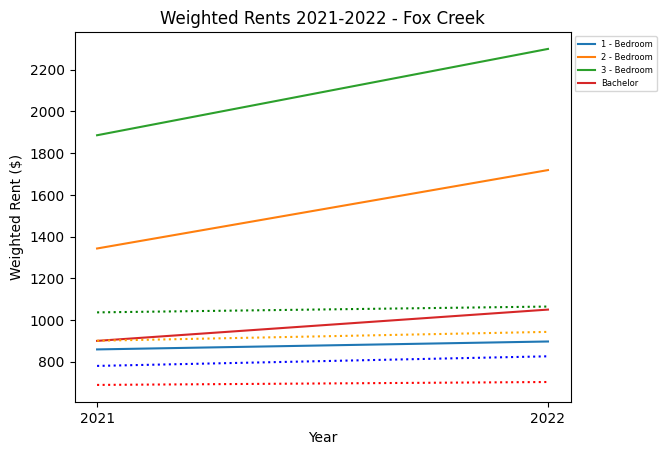

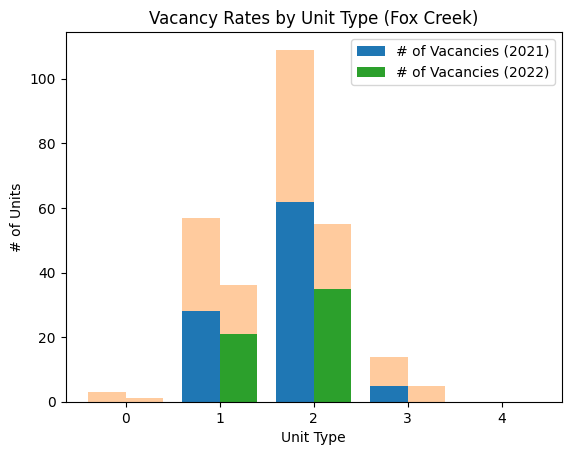

In [19]:
# Why we used this? --> Extreme Case 2: Fox Creek (Increases in all and are above the mean rent --> massive difference from rent prices)
for i in range(len(foxcreek.index)):
    plt.plot(["2021", "2022"], foxcreek_rents.iloc[i], label=foxcreek["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Fox Creek") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

vacancy_2021 = np.array(foxcreek_vacancies["2021"].loc["Vacancies"])
vacancy_2022 = np.array(foxcreek_vacancies["2022"].loc["Vacancies"])

num_units_2021 = np.array(foxcreek_vacancies["2021"].loc["Number of Units"])
num_units_2022 = np.array(foxcreek_vacancies["2022"].loc["Number of Units"])

x_range = np.arange(len(foxcreek_vacancies["2021"].columns)) # create (also allows us to offset the bars)

plt.bar(x_range - 0.2, vacancy_2021, 0.4, label="# of Vacancies (2021)")
plt.bar(x_range - 0.2, num_units_2021 - vacancy_2021, 0.4, bottom=vacancy_2021, alpha=0.4)
plt.bar(x_range + 0.2, vacancy_2022, 0.4, color="C2", label="# of Vacancies (2022)")
plt.bar(x_range + 0.2, num_units_2022 - vacancy_2022, 0.4, bottom=vacancy_2022, alpha=0.4, color="C1")
plt.title("Vacancy Rates by Unit Type (Fox Creek)")
plt.xlabel("Unit Type")
plt.ylabel("# of Units")
plt.legend()
plt.show()

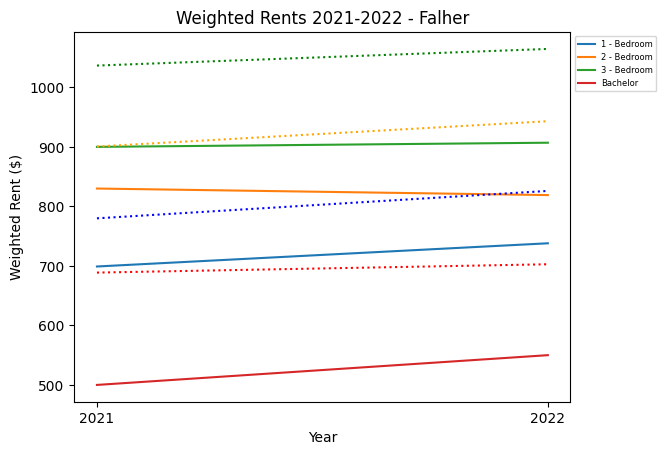

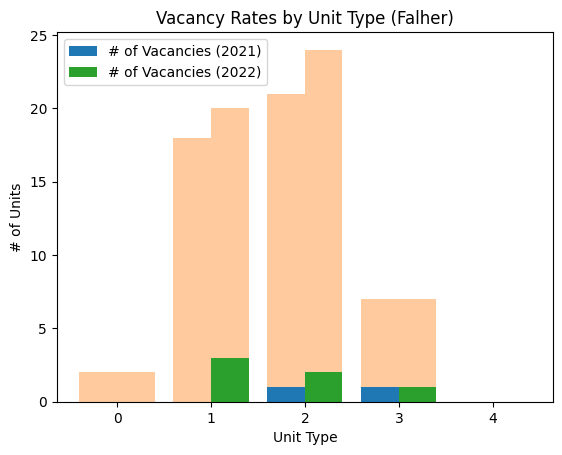

In [20]:
# Why we used this? --> Below the Average Rent for all --> Relatively Stable??
for i in range(len(falher.index)):
    plt.plot(["2021", "2022"], falher_rents.iloc[i], label=falher["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Falher") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

vacancy_2021 = np.array(falher_vacancies["2021"].loc["Vacancies"])
vacancy_2022 = np.array(falher_vacancies["2022"].loc["Vacancies"])

num_units_2021 = np.array(falher_vacancies["2021"].loc["Number of Units"])
num_units_2022 = np.array(falher_vacancies["2022"].loc["Number of Units"])

x_range = np.arange(len(falher_vacancies["2021"].columns)) # create (also allows us to offset the bars)

plt.bar(x_range - 0.2, vacancy_2021, 0.4, label="# of Vacancies (2021)")
plt.bar(x_range - 0.2, num_units_2021 - vacancy_2021, 0.4, bottom=vacancy_2021, alpha=0.4)
plt.bar(x_range + 0.2, vacancy_2022, 0.4, color="C2", label="# of Vacancies (2022)")
plt.bar(x_range + 0.2, num_units_2022 - vacancy_2022, 0.4, bottom=vacancy_2022, alpha=0.4, color="C1")
plt.title("Vacancy Rates by Unit Type (Falher)")
plt.xlabel("Unit Type")
plt.ylabel("# of Units")
plt.legend()
plt.show()

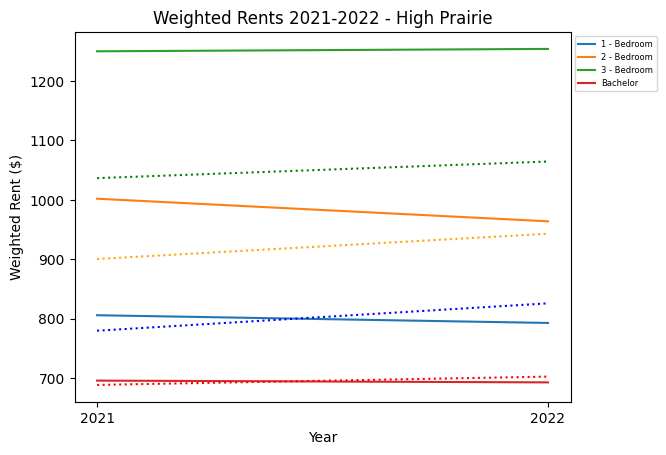

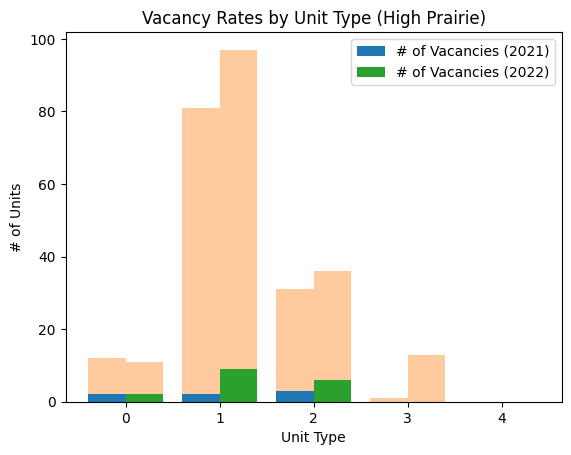

In [21]:
# Why we used this? --> most are below average --> decreaseing except for 3-bed, which is high and is stable
for i in range(len(highprairie.index)):
    plt.plot(["2021", "2022"], highprairie_rents.iloc[i], label=highprairie["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - High Prairie") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

vacancy_2021 = np.array(highprairie_vacancies["2021"].loc["Vacancies"])
vacancy_2022 = np.array(highprairie_vacancies["2022"].loc["Vacancies"])

num_units_2021 = np.array(highprairie_vacancies["2021"].loc["Number of Units"])
num_units_2022 = np.array(highprairie_vacancies["2022"].loc["Number of Units"])

x_range = np.arange(len(highprairie_vacancies["2021"].columns)) # create (also allows us to offset the bars)

plt.bar(x_range - 0.2, vacancy_2021, 0.4, label="# of Vacancies (2021)")
plt.bar(x_range - 0.2, num_units_2021 - vacancy_2021, 0.4, bottom=vacancy_2021, alpha=0.4)
plt.bar(x_range + 0.2, vacancy_2022, 0.4, color="C2", label="# of Vacancies (2022)")
plt.bar(x_range + 0.2, num_units_2022 - vacancy_2022, 0.4, bottom=vacancy_2022, alpha=0.4, color="C1")
plt.title("Vacancy Rates by Unit Type (High Prairie)")
plt.xlabel("Unit Type")
plt.ylabel("# of Units")
plt.legend()
plt.show()

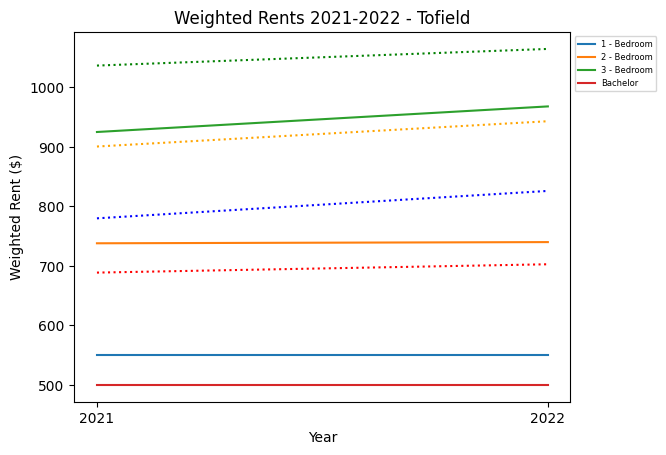

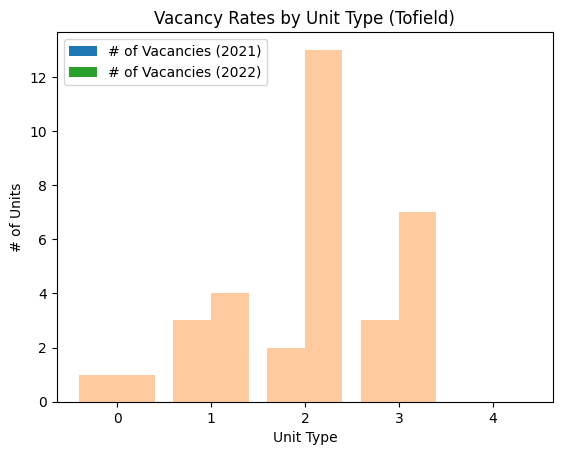

In [22]:
# Why we used this? --> much lower prices compared to average
for i in range(len(tofield.index)):
    plt.plot(["2021", "2022"], tofield_rents.iloc[i], label=tofield["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Tofield") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

vacancy_2021 = np.array(tofield_vacancies["2021"].loc["Vacancies"])
vacancy_2022 = np.array(tofield_vacancies["2022"].loc["Vacancies"])

num_units_2021 = np.array(tofield_vacancies["2021"].loc["Number of Units"])
num_units_2022 = np.array(tofield_vacancies["2022"].loc["Number of Units"])

x_range = np.arange(len(tofield_vacancies["2021"].columns)) # create (also allows us to offset the bars)

plt.bar(x_range - 0.2, vacancy_2021, 0.4, label="# of Vacancies (2021)")
plt.bar(x_range - 0.2, num_units_2021 - vacancy_2021, 0.4, bottom=vacancy_2021, alpha=0.4)
plt.bar(x_range + 0.2, vacancy_2022, 0.4, color="C2", label="# of Vacancies (2022)")
plt.bar(x_range + 0.2, num_units_2022 - vacancy_2022, 0.4, bottom=vacancy_2022, alpha=0.4, color="C1")
plt.title("Vacancy Rates by Unit Type (Tofield)")
plt.xlabel("Unit Type")
plt.ylabel("# of Units")
plt.legend()
plt.show()

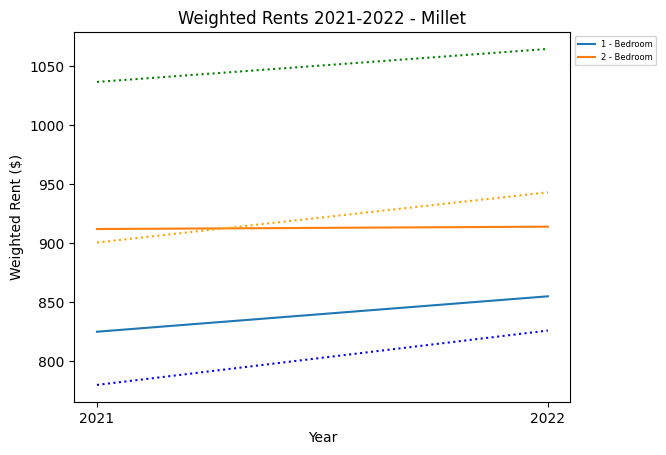

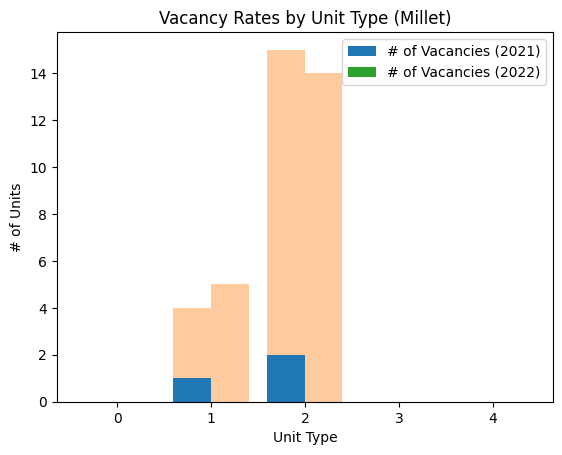

In [23]:
# Why we used this? --> Less Housing Units --> mostly above/around average
for i in range(len(millet.index)):
    plt.plot(["2021", "2022"], millet_rents.iloc[i], label=millet["Unit Type"].iloc[i])

plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Millet") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

vacancy_2021 = np.array(millet_vacancies["2021"].loc["Vacancies"])
vacancy_2022 = np.array(millet_vacancies["2022"].loc["Vacancies"])

num_units_2021 = np.array(millet_vacancies["2021"].loc["Number of Units"])
num_units_2022 = np.array(millet_vacancies["2022"].loc["Number of Units"])

x_range = np.arange(len(millet_vacancies["2021"].columns)) # create (also allows us to offset the bars)

plt.bar(x_range - 0.2, vacancy_2021, 0.4, label="# of Vacancies (2021)")
plt.bar(x_range - 0.2, num_units_2021 - vacancy_2021, 0.4, bottom=vacancy_2021, alpha=0.4)
plt.bar(x_range + 0.2, vacancy_2022, 0.4, color="C2", label="# of Vacancies (2022)")
plt.bar(x_range + 0.2, num_units_2022 - vacancy_2022, 0.4, bottom=vacancy_2022, alpha=0.4, color="C1")
plt.title("Vacancy Rates by Unit Type (Millet)")
plt.xlabel("Unit Type")
plt.ylabel("# of Units")
plt.legend()
plt.show()

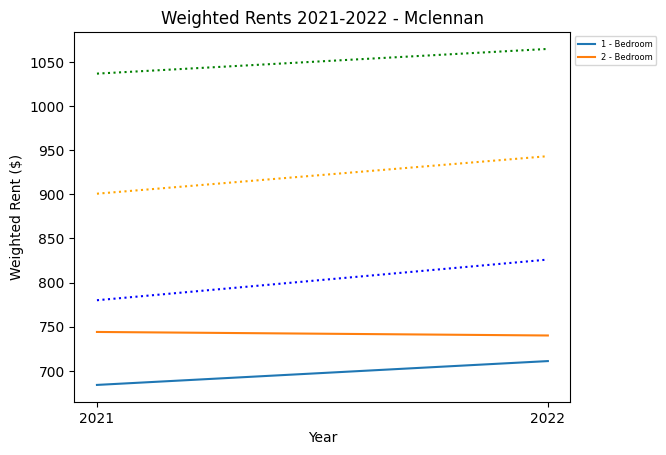

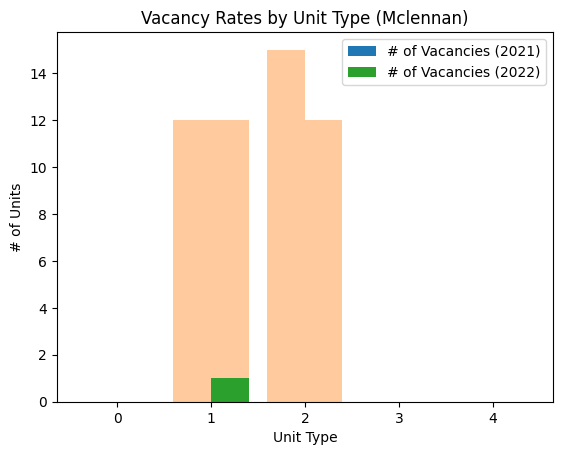

In [24]:
# # Why we used this? --> Less Housing Units --> below average 
for i in range(len(mclennan.index)):
    plt.plot(["2021", "2022"], mclennan_rents.iloc[i], label=mclennan["Unit Type"].iloc[i])

plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Mclennan") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

vacancy_2021 = np.array(mclennan_vacancies["2021"].loc["Vacancies"])
vacancy_2022 = np.array(mclennan_vacancies["2022"].loc["Vacancies"])

num_units_2021 = np.array(mclennan_vacancies["2021"].loc["Number of Units"])
num_units_2022 = np.array(mclennan_vacancies["2022"].loc["Number of Units"])

x_range = np.arange(len(mclennan_vacancies["2021"].columns)) # create (also allows us to offset the bars)

plt.bar(x_range - 0.2, vacancy_2021, 0.4, label="# of Vacancies (2021)")
plt.bar(x_range - 0.2, num_units_2021 - vacancy_2021, 0.4, bottom=vacancy_2021, alpha=0.4)
plt.bar(x_range + 0.2, vacancy_2022, 0.4, color="C2", label="# of Vacancies (2022)")
plt.bar(x_range + 0.2, num_units_2022 - vacancy_2022, 0.4, bottom=vacancy_2022, alpha=0.4, color="C1")
plt.title("Vacancy Rates by Unit Type (Mclennan)")
plt.xlabel("Unit Type")
plt.ylabel("# of Units")
plt.legend()
plt.show()

### Overall Vacancy Rates between 2021-2022

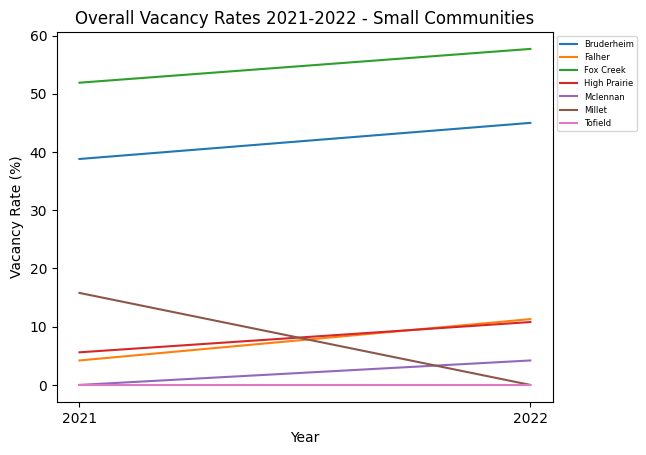

In [25]:
# small town vacancies
vacancy_smalltowns_num = vacancy_smalltowns[["2021 Vacancy", "2022 Vacancy"]]
for i in range(len(vacancy_smalltowns.index)):
    plt.plot(["2021", "2022"], vacancy_smalltowns_num.iloc[i], label=vacancy_smalltowns["Community"].iloc[i])

plt.title("Overall Vacancy Rates 2021-2022 - Small Communities") 
plt.xlabel("Year")
plt.ylabel("Vacancy Rate (%)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

- When most are Below Average --> Overall Smaller Vacancy Rates (High Prairie, Falher)
- When most are Above Average --> Overall larger Vacancy Rates (Bruderheim, Fox Creek)
- Increase in Vacancy Rates between the two years overall for the aforementioned cases
- Overall relatively more drastic patterns I think (we will see later)

<u>Note</u>:
- Main idea with small towns is smaller rents usually due to smaller populations, so might this affect vacancy rates?
- Usually less housing types or smaller rents noticed compared to average, keep note of this
- Falher and Tofield might be interesting since both have similar trends but Falher has more decrease
- Even if nothing remarkable comes of this, still remark it

<br>

- Noticed that cases with massive diffence from average will usually have high vacancy rates and increase in it, regradless of town size
- Less Unit Types --> Less Units --> Probably why no vacancies maybe --> both have similar trends but millet has a higher price roof than mclennan, and has a decrease in vacancy rates whereas mclennan had an increase

---------------------------------

## **Analysis of Medium Communities**

*Population Size: (2493-5760)*

In [26]:
# list of medium towns (size 2493-5760)
med_towns = table9_cleaned[table9_cleaned["2022"].between(population_bins[1], population_bins[2], inclusive='right')]
med_towns

,Area Name,Type,2022
308,Athabasca,T,2827
296,Barrhead,T,4503
85,Black Diamond,T,2825
29,Cardston,T,3828
96,Carstairs,T,5181
38,Claresholm,T,3957
98,Didsbury,T,5172
425,Fairview,T,2914
36,Fort Macleod,T,3499
402,Grande Cache,T,3276


In [27]:
medtowns = ["Jasper","Barrhead","Westlock", "Claresholm", "Grimshaw", "Raymond", "Fort Macleod"]

costs_medtowns = table8[table8["Community"].isin(medtowns)]
vacancy_medtowns = table6[table6["Community"].isin(medtowns)]

jasper = costs_medtowns[costs_medtowns["Community"] == "Jasper"]
barrhead = costs_medtowns[costs_medtowns["Community"] == "Barrhead"]
westlock = costs_medtowns[costs_medtowns["Community"] == "Westlock"]
claresholm = costs_medtowns[costs_medtowns["Community"] == "Claresholm"]
grimshaw = costs_medtowns[costs_medtowns["Community"] == "Grimshaw"]
raymond = costs_medtowns[costs_medtowns["Community"] == "Raymond"]
fortmac = costs_medtowns[costs_medtowns["Community"] == "Fort Macleod"]

jasper_rents = jasper[["2021 Weighted Rent", "2022 Weighted Rent"]]
barrhead_rents = barrhead[["2021 Weighted Rent", "2022 Weighted Rent"]]
westlock_rents = westlock[["2021 Weighted Rent", "2022 Weighted Rent"]]
claresholm_rents = claresholm[["2021 Weighted Rent", "2022 Weighted Rent"]]
grimshaw_rents = grimshaw[["2021 Weighted Rent", "2022 Weighted Rent"]]
raymond_rents = raymond[["2021 Weighted Rent", "2022 Weighted Rent"]]
fortmac_rents = fortmac[["2021 Weighted Rent", "2022 Weighted Rent"]]

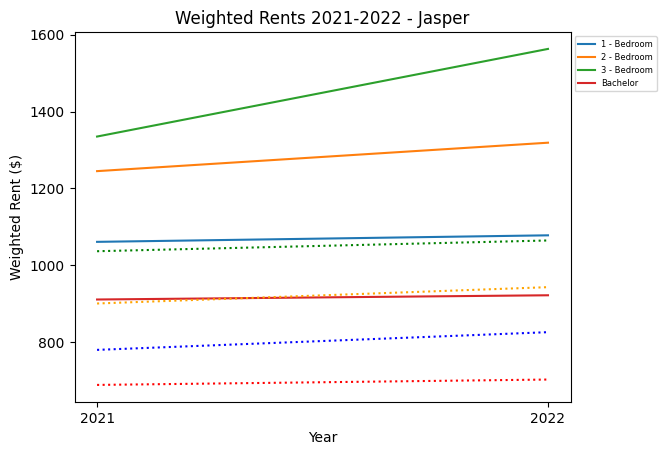

In [28]:
# Why we used this? --> Less Housing Units --> mostly above/around average
for i in range(len(jasper.index)):
    plt.plot(["2021", "2022"], jasper_rents.iloc[i], label=jasper["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Jasper") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

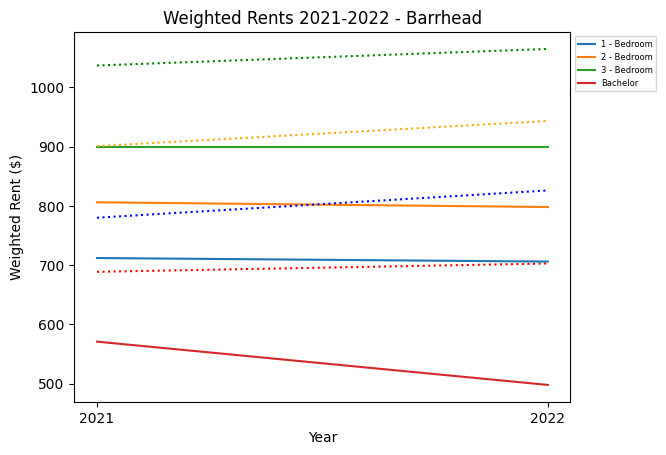

In [29]:
# Why we used this? --> 
for i in range(len(barrhead.index)):
    plt.plot(["2021", "2022"], barrhead_rents.iloc[i], label=barrhead["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Barrhead") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

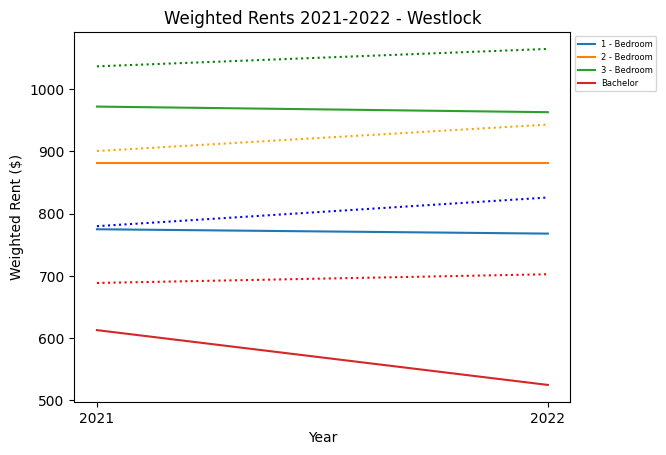

In [30]:
# Why we used this? --> Less Housing Units --> mostly above/around average
for i in range(len(westlock.index)):
    plt.plot(["2021", "2022"], westlock_rents.iloc[i], label=westlock["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Westlock") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

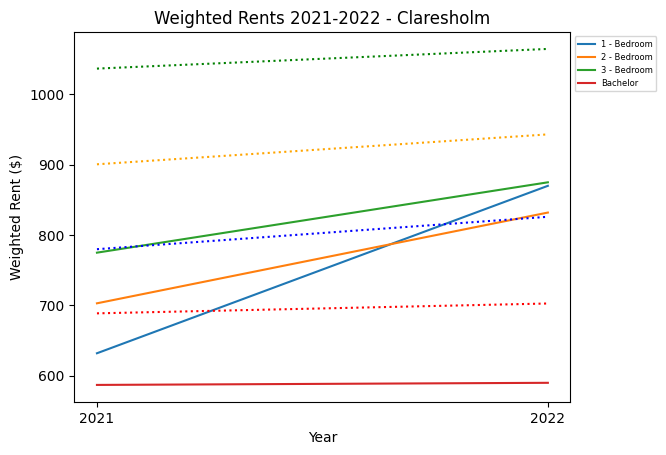

In [31]:
# Why we used this? --> lower prices for all but increase 
for i in range(len(claresholm.index)):
    plt.plot(["2021", "2022"], claresholm_rents.iloc[i], label=claresholm["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Claresholm") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

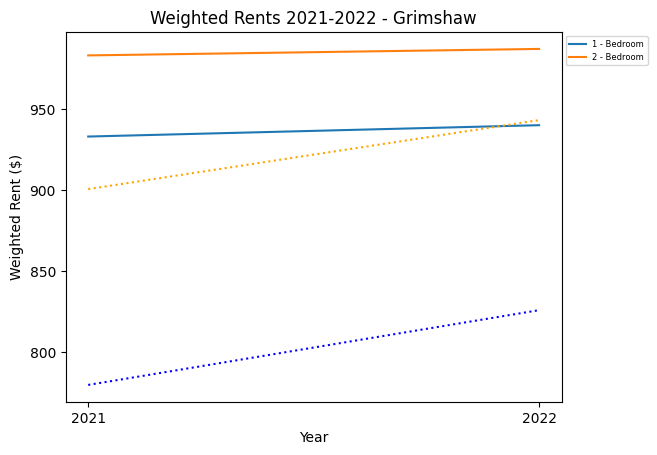

In [32]:
# Why we used this? -->
for i in range(len(grimshaw.index)):
    plt.plot(["2021", "2022"], grimshaw_rents.iloc[i], label=grimshaw["Unit Type"].iloc[i])

plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.title("Weighted Rents 2021-2022 - Grimshaw") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

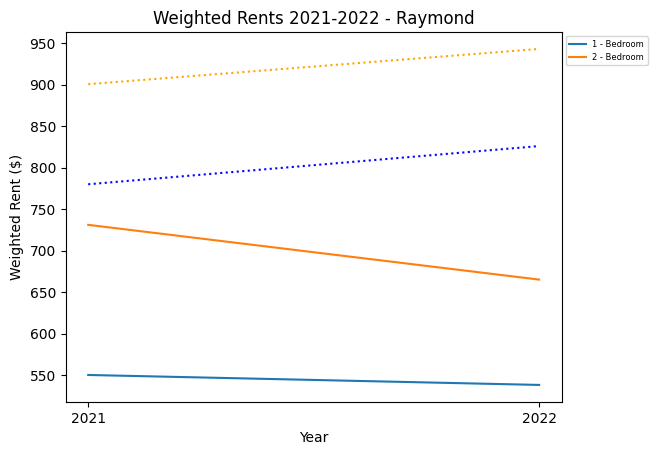

In [33]:
# Why we used this? -->
for i in range(len(raymond.index)):
    plt.plot(["2021", "2022"], raymond_rents.iloc[i], label=raymond["Unit Type"].iloc[i])

plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.title("Weighted Rents 2021-2022 - Raymond") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

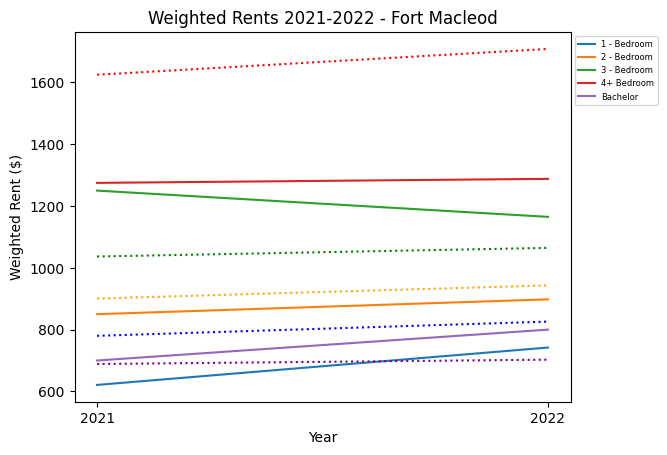

In [34]:
# Why we used this? --> Includes 4+ Town --> Compare w/ Banff
for i in range(len(fortmac.index)):
    plt.plot(["2021", "2022"], fortmac_rents.iloc[i], label=fortmac["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="purple")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.plot([mean_4beds2021, mean_4beds2022], linestyle='dotted', color="r")
plt.title("Weighted Rents 2021-2022 - Fort Macleod") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

### Overall Vacancy Rates between 2021-2022

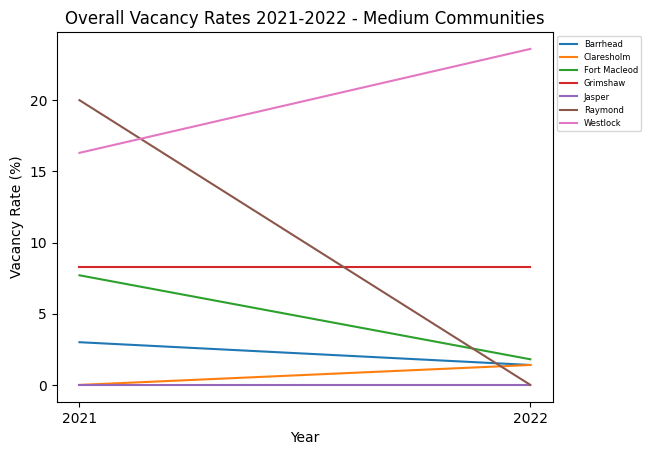

In [35]:
vacancy_medtowns_num = vacancy_medtowns[["2021 Vacancy", "2022 Vacancy"]]
for i in range(len(vacancy_medtowns.index)):
    plt.plot(["2021", "2022"], vacancy_medtowns_num.iloc[i], label=vacancy_medtowns["Community"].iloc[i])

plt.title("Overall Vacancy Rates 2021-2022 - Medium Communities") 
plt.xlabel("Year")
plt.ylabel("Vacancy Rate (%)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

<u>Notes</u>:
- dd

----------------------------------
## **Analysis of Large Communities**

*Population Size: (5761-14,996)*

In [36]:
# list of large towns (size 5760-14996)
big_towns = table9_cleaned[table9_cleaned["2022"].between(population_bins[2], population_bins[3], inclusive='right')]
big_towns

,Area Name,Type,2022
330,Banff,T,9347
150,Blackfalds,T,11363
256,Bonnyville,T,6632
18,Coaldale,T,9179
322,Crowsnest Pass,SM,5910
226,Drayton Valley,T,7482
68,Drumheller,T,8231
320,Edson,T,8399
81,High River,T,14996
319,Hinton,T,9933


In [37]:
# Edson --> good for seeing how higher average rent roof affects but not like outliers i think
# Hinton --> on average higher prices, but 2 > 3
# Rocky Mountain House --> Variability
# Wainwright --> Especially low bachelor

bigtowns = ["Slave Lake", "Ponoka", "Banff", "Peace River", "Taber", "Edson", "Wainwright"]

costs_bigtowns = table8[table8["Community"].isin(bigtowns)]
vacancy_bigtowns = table6[table6["Community"].isin(bigtowns)]

slavelake = costs_bigtowns[costs_bigtowns["Community"] == "Slave Lake"]
ponoka = costs_bigtowns[costs_bigtowns["Community"] == "Ponoka"] # compare with High prairie for example to see how individual units may affec whole thing (3-bed)
banff = costs_bigtowns[costs_bigtowns["Community"] == "Banff"]
peaceriver = costs_bigtowns[costs_bigtowns["Community"] == "Peace River"]
taber = costs_bigtowns[costs_bigtowns["Community"] == "Taber"] # Taber --> Increase + Lower Roofs, potentially compare with claresholm
edson = costs_bigtowns[costs_bigtowns["Community"] == "Edson"] # good for seeing how higher average rent roof affects but not like outliers i think
wainwright = costs_bigtowns[costs_bigtowns["Community"] == "Wainwright"] # Especially low bachelor --> could potentially compare with sundre for similar to Ponoka vs High Praire --> Individual Units affect???

slavelake_rents = slavelake[["2021 Weighted Rent", "2022 Weighted Rent"]]
ponoka_rents = ponoka[["2021 Weighted Rent", "2022 Weighted Rent"]]
banff_rents = banff[["2021 Weighted Rent", "2022 Weighted Rent"]]
peaceriver_rents = peaceriver[["2021 Weighted Rent", "2022 Weighted Rent"]]
taber_rents = taber[["2021 Weighted Rent", "2022 Weighted Rent"]]
edson_rents = edson[["2021 Weighted Rent", "2022 Weighted Rent"]]
wainwright_rents = wainwright[["2021 Weighted Rent", "2022 Weighted Rent"]]

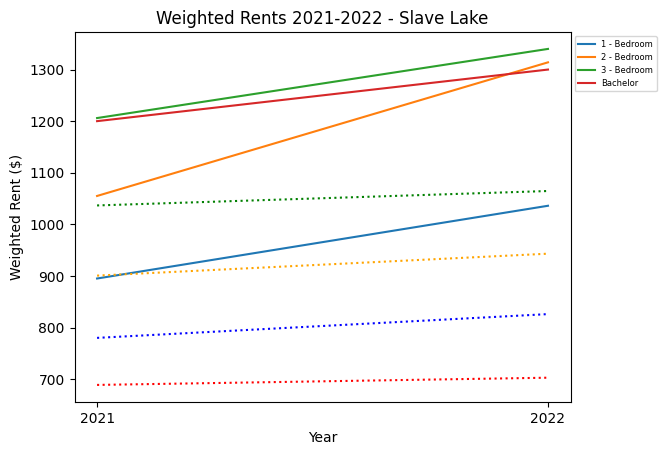

In [38]:
# Why we used this? -->
for i in range(len(slavelake.index)):
    plt.plot(["2021", "2022"], slavelake_rents.iloc[i], label=slavelake["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Slave Lake") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

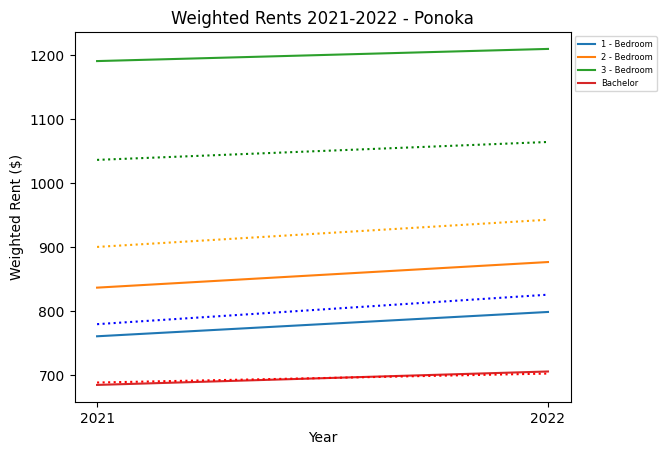

In [39]:
# Why we used this? -->
for i in range(len(ponoka.index)):
    plt.plot(["2021", "2022"], ponoka_rents.iloc[i], label=ponoka["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Ponoka") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

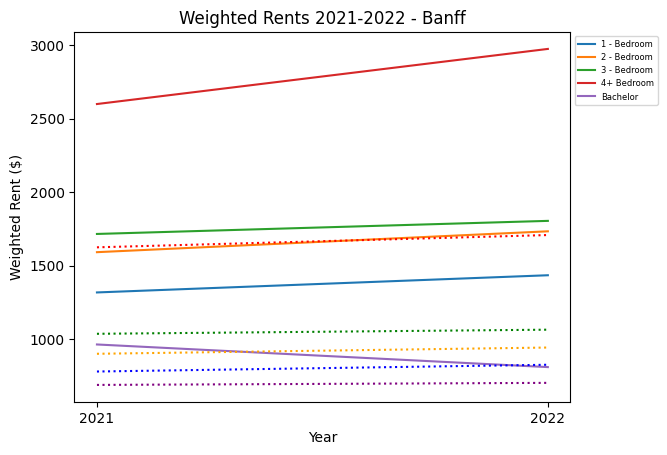

In [40]:
# Why we used this? -->
for i in range(len(banff.index)):
    plt.plot(["2021", "2022"], banff_rents.iloc[i], label=banff["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="purple")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.plot([mean_4beds2021, mean_4beds2022], linestyle='dotted', color="r")
plt.title("Weighted Rents 2021-2022 - Banff") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

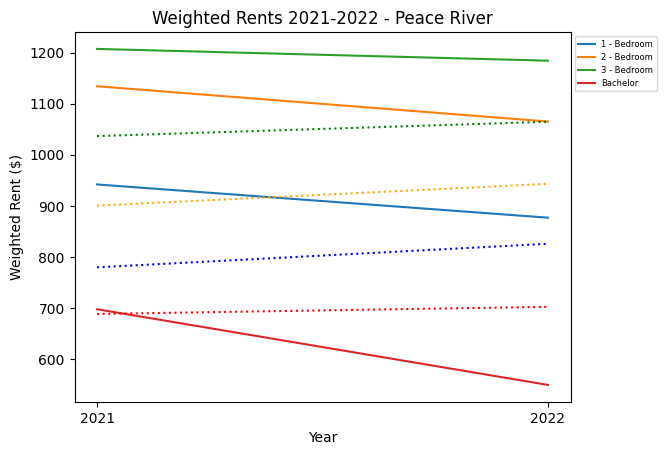

In [41]:
# Why we used this? -->
for i in range(len(peaceriver.index)):
    plt.plot(["2021", "2022"], peaceriver_rents.iloc[i], label=peaceriver["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Peace River") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

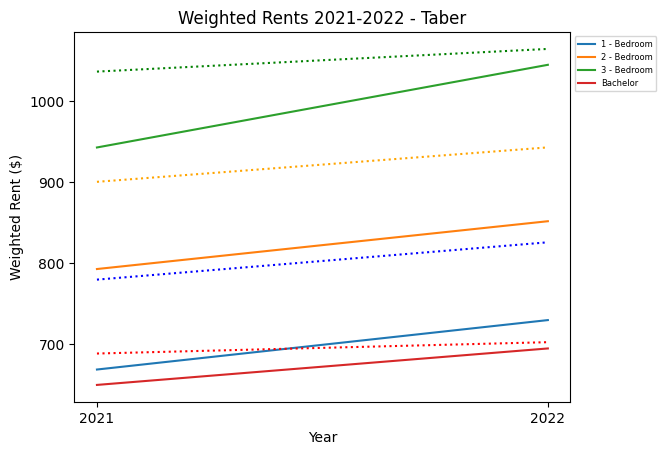

In [42]:
# Why we used this? -->
for i in range(len(taber.index)):
    plt.plot(["2021", "2022"], taber_rents.iloc[i], label=taber["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Taber") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

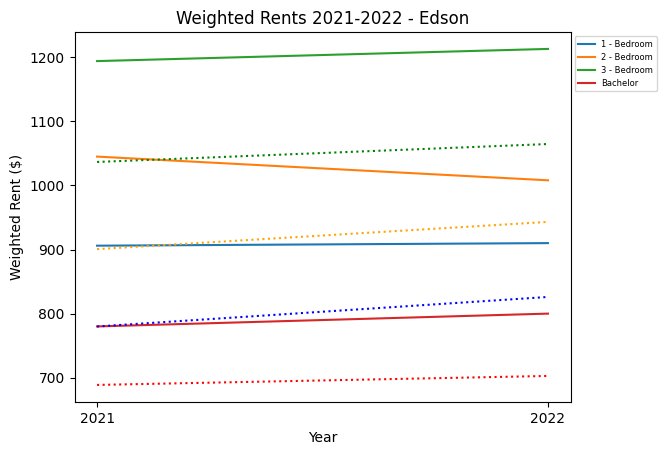

In [43]:
# Why we used this? -->
for i in range(len(edson.index)):
    plt.plot(["2021", "2022"], edson_rents.iloc[i], label=edson["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Edson") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

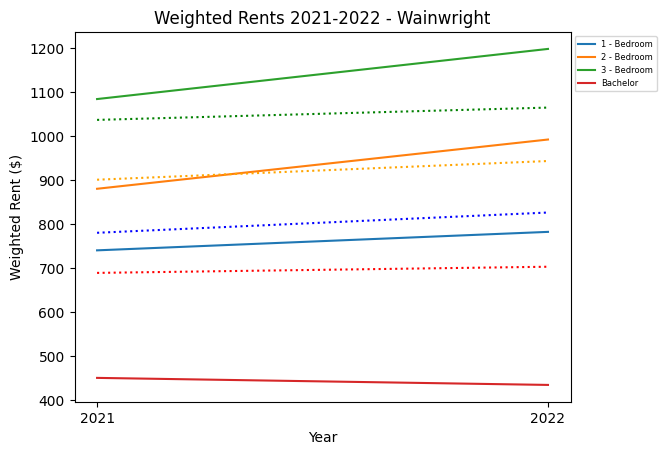

In [44]:
# Why we used this? -->
for i in range(len(wainwright.index)):
    plt.plot(["2021", "2022"], wainwright_rents.iloc[i], label=wainwright["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Wainwright") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

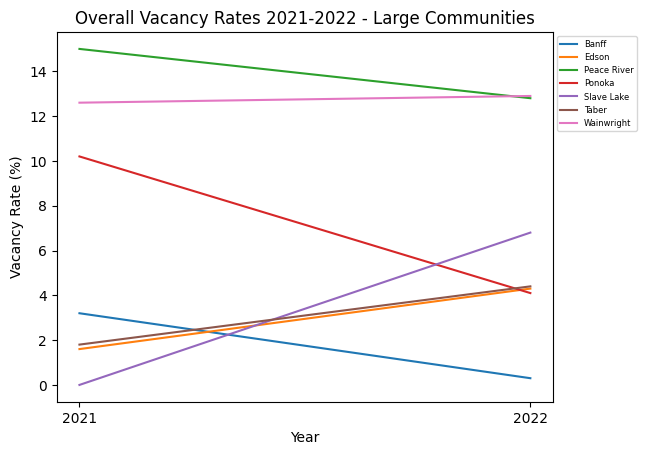

In [45]:
# Why we used this? -->
vacancy_bigtowns_num = vacancy_bigtowns[["2021 Vacancy", "2022 Vacancy"]]
for i in range(len(vacancy_bigtowns.index)):
    plt.plot(["2021", "2022"], vacancy_bigtowns_num.iloc[i], label=vacancy_bigtowns["Community"].iloc[i])

plt.title("Overall Vacancy Rates 2021-2022 - Large Communities") 
plt.xlabel("Year")
plt.ylabel("Vacancy Rate (%)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

-----